In [438]:
import numpy as np
import pandas as pd
import pickle
from pandas import json_normalize
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Loads simulations performance metrics.

In [ ]:
orderbook_updates = [10, 20, 30, 50, 100, 200, 300, 500, 1000, 10000] 
ROOT_DIR = "/home/mp422/data_processing"
TICKERS = ["MELI","PANW","ARM"]
Ws = [5,6,7,8,9,10,11,12,13,14]
horizons = [0,8,9]
model_list = ["deepLOB_L2","deepOF_L2","deepVOL_L2"]
train_labels = ["uniform_mid_returns","pit_mid_returns","ask_bid_returns","latency_300_mid_returns","latency_3000_mid_returns"]
# test_labels = ["uniform_mid_returns","pit_mid_returns","bid_ask_returns"]
test_labels = ["uniform_mid_returns","pit_mid_returns","ask_bid_returns","latency_300_mid_returns","latency_3000_mid_returns"]
eval_types = ["train","val","test"]

In [ ]:
df_list = []
for m, model_type in enumerate(model_list):
    model_filepath = os.path.join(ROOT_DIR, "results", model_type)
    for TICKER in TICKERS:
        TICKER_filepath = os.path.join(model_filepath, TICKER)
        for W in Ws:
            window_filepath = os.path.join(TICKER_filepath, "W" + str(W))
            for train_label in train_labels:
                for test_label in test_labels:
                    for horizon in horizons:
                        results_filepath = os.path.join(window_filepath, "h" + str(orderbook_updates[horizon]), "|".join(["train:" + train_label, "test:" + test_label]))
                        
                        for eval_type in eval_types:
                            print("results path:", results_filepath, f": {eval_type}")

                            classification_report_path = os.path.join(results_filepath, f"classification_report_{eval_type}.pkl")
                            if os.path.exists(classification_report_path):
                                with open(classification_report_path, "rb") as file:
                                    classification_report = pickle.load(file)
                            else:
                                print("classification report file does not exist.")

                            categorical_crossentropy_path = os.path.join(results_filepath, f"categorical_crossentropy_{eval_type}.pkl")
                            if os.path.exists(categorical_crossentropy_path):
                                with open(categorical_crossentropy_path, "rb") as file:
                                    categorical_crossentropy = pickle.load(file)
                            else:
                                print("categorical crossentropy file does not exist.")

                            if os.path.exists(classification_report_path) and os.path.exists(categorical_crossentropy_path):
                                df = json_normalize(classification_report)
                                df.insert(0, "ticker", TICKER)
                                df.insert(1, "window", W)
                                df.insert(2, "model_type", model_type)
                                df.insert(3, "horizon", horizon)
                                df.insert(4, "train_label", train_label)
                                df.insert(5, "test_label", test_label)
                                df.insert(6, "eval_type", eval_type)
                                df.insert(7, "categorical_crossentropy", categorical_crossentropy)
                                df_list.append(df)
                            else:
                                print("Data was not added.")
                            

                        
consolidated_results_df = pd.concat(df_list)

# Ljung-Box Tests

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.multitest import multipletests

In [ ]:
# t-test alpha
alpha = 0.05

In [444]:
def test_acorr_ljungbox(tickers, model_types, horizons, train_labels, test_labels, eval_types, metric):
    ljung_box_result_df_list = []
    for ticker in tickers:
        for model_type in model_types:
            for horizon in horizons:
                for train_label in train_labels:
                    for test_label in test_labels:
                        for eval_type in eval_types:
                            metrics = consolidated_results_df[
                                (consolidated_results_df["ticker"] == ticker) &
                                (consolidated_results_df["model_type"] == model_type) &
                                (consolidated_results_df["horizon"] == horizon) &
                                (consolidated_results_df["train_label"] == train_label) &
                                (consolidated_results_df["test_label"] == test_label) &
                                (consolidated_results_df["eval_type"] == eval_type)
                                ][metric]
                            if len(metrics) > 0:
                                ljung_box_result_df = acorr_ljungbox(metrics, lags=[i + 1 for i in range(9)], return_df=False)
                                ljung_box_result_df.insert(0, "ticker", ticker)
                                ljung_box_result_df.insert(1, "model_type", model_type)
                                ljung_box_result_df.insert(2, "horizon", horizon)
                                ljung_box_result_df.insert(3, "train_label", train_label)
                                ljung_box_result_df.insert(4, "test_label", test_label)
                                ljung_box_result_df.insert(5, "eval_type", eval_type)
                                ljung_box_result_df.insert(6, "metric", metric)
                                ljung_box_result_df.insert(7, "lag", [i + 1 for i in range(9)])
                                ljung_box_result_df_list.append(ljung_box_result_df)
    return pd.concat(ljung_box_result_df_list)

In [445]:
test_acorr_ljungbox_cons_df = test_acorr_ljungbox(tickers=["MELI","PANW","ARM"],
                    model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
                    horizons=[0,8,9],
                    train_labels=["uniform_mid_returns","pit_mid_returns","ask_bid_returns","latency_300_mid_returns","latency_3000_mid_returns"],
                    test_labels=["uniform_mid_returns","pit_mid_returns","ask_bid_returns","latency_300_mid_returns","latency_3000_mid_returns"],
                    eval_types=["train","val","test"],
                    metric="categorical_crossentropy")

In [454]:
evaluated_combinations = {
    0 : {"train":"uniform_mid_returns",
         "test":"uniform_mid_returns"},
    1: {"train":"uniform_mid_returns",
        "test":"pit_mid_returns"},
    2: {"train":"uniform_mid_returns",
        "test":"ask_bid_returns"},
    3: {"train":"uniform_mid_returns",
        "test":"latency_300_mid_returns"},
    4: {"train":"pit_mid_returns",
        "test":"pit_mid_returns"},
    5: {"train":"pit_mid_returns",
        "test":"ask_bid_returns"},
    6 : {"train":"pit_mid_returns",
         "test":"latency_300_mid_returns"}
}

In [456]:
valid_test_acorr_ljungbox_cons_df_list = []

for i in evaluated_combinations:
    print(evaluated_combinations[i]["train"])
    print(evaluated_combinations[i]["test"])
    valid_df = test_acorr_ljungbox_cons_df[(test_acorr_ljungbox_cons_df["train_label"] == evaluated_combinations[i]["train"]) &
                                            (test_acorr_ljungbox_cons_df["test_label"] == evaluated_combinations[i]["test"])]
    valid_test_acorr_ljungbox_cons_df_list.append(valid_df)

valid_test_acorr_ljungbox_cons_df = pd.concat(valid_test_acorr_ljungbox_cons_df_list)

uniform_mid_returns
uniform_mid_returns
uniform_mid_returns
pit_mid_returns
uniform_mid_returns
ask_bid_returns
uniform_mid_returns
latency_300_mid_returns
pit_mid_returns
pit_mid_returns
pit_mid_returns
ask_bid_returns
pit_mid_returns
latency_300_mid_returns


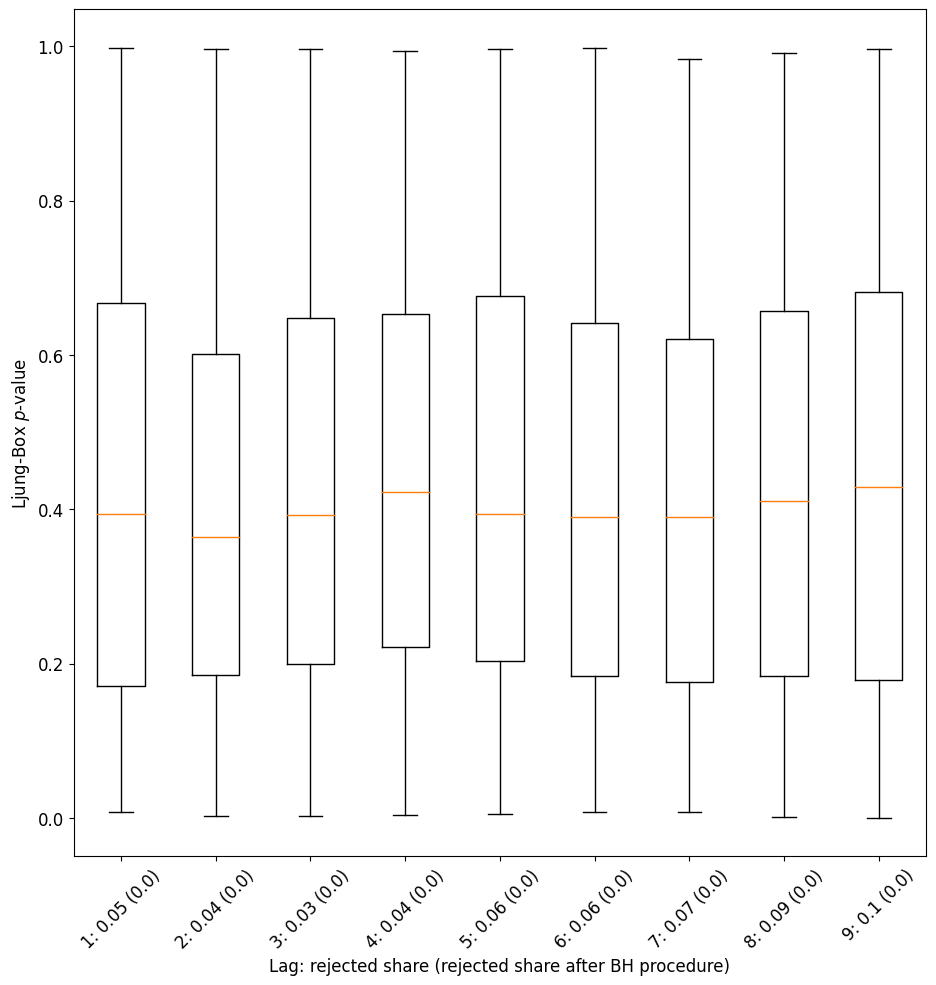

In [458]:
plt.figure(figsize=[11,11])
plt.rcParams.update({'font.size': 12})

# Combine the data into a list of arrays/lists
data = []
labels = []

for lag in range(1,10):
    lag_lb_pvals = valid_test_acorr_ljungbox_cons_df[valid_test_acorr_ljungbox_cons_df["lag"] == lag]["lb_pvalue"]
    
    m = len(lag_lb_pvals)
    
    rejected = lag_lb_pvals < alpha
    rejected_corrected = multipletests(lag_lb_pvals, alpha=alpha, method="fdr_bh")[0]
    
    rejected_share = rejected.sum() / m
    rejected_corrected_share = rejected_corrected.sum() / m

    label = f"{lag}: {round(rejected_share,2)} ({round(rejected_corrected_share,2)})"

    data.append(lag_lb_pvals)
    labels.append(label)
    

# Create a box plot
plt.boxplot(data)

# Set the labels for each box plot
plt.xticks([i for i in range(1,10)], labels)

# Add a title and labels
plt.xlabel("Lag: rejected share (rejected share after BH procedure)")
plt.ylabel(r"Ljung-Box $p$-value")
plt.xticks(rotation=45)

# Show the plot
plt.savefig("lb_boxplot.pdf", format="pdf")
plt.show()

In [334]:
m = len(test_acorr_ljungbox_cons_df)

rejected = test_acorr_ljungbox_cons_df["lb_pvalue"] < alpha
rejected_corrected = multipletests(test_acorr_ljungbox_cons_df["lb_pvalue"], alpha=alpha, method="fdr_bh")[0]

rejected_share = rejected.sum() / m
rejected_corrected_share = rejected_corrected.sum() / m

print(f"rejected share: {rejected_share}")
print(f"rejected corrected share: {rejected_corrected_share}")

rejected share: 0.05909922267946959
rejected corrected share: 0.0


In [459]:
print("Number of tests: ", len(valid_test_acorr_ljungbox_cons_df))
print("Number of tests per lag: ", len(valid_test_acorr_ljungbox_cons_df) / 9)

Number of tests:  6804
Number of tests per lag:  756.0


# Predictive performance analysis

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

In [460]:
# Functions to run and plot the analysis.

def plot_timeseries(eval_type, model_type, metric, test_label1, test_label2):
    y1 = consolidated_results_df[(consolidated_results_df["eval_type"] == eval_type) & 
                (consolidated_results_df["test_label"] == test_label1) &
                (consolidated_results_df["model_type"] == model_type)][metric]

    y2 = consolidated_results_df[(consolidated_results_df["eval_type"] == eval_type) & 
                (consolidated_results_df["test_label"] == test_label2) &
                (consolidated_results_df["model_type"] == model_type)][metric]

    p = stats.ttest_ind(y1, y2 ,equal_var=False, alternative="two-sided").pvalue

    plt.plot(Ws, y1, label=test_label1)
    plt.plot(Ws, y2, label=test_label2)
    plt.legend()
    plt.title(metric + f" (p-value={round(p, 2)})")
    plt.show();


def summarize_results(eval_type, tickers, horizons, model_types, metrics, train_label_control, test_label_control, train_label_test, test_label_test):
    df_list = []
    for model_type in model_types:
        for ticker in tickers:
            for horizon in horizons:
                metric_dicts = {}
                for metric in metrics:
                    metric_control = consolidated_results_df[
                                (consolidated_results_df["ticker"] == ticker) &
                                (consolidated_results_df["horizon"] == horizon) &
                                (consolidated_results_df["eval_type"] == eval_type) &
                                (consolidated_results_df["train_label"] == train_label_control) &
                                (consolidated_results_df["test_label"] == test_label_control) &
                                (consolidated_results_df["model_type"] == model_type)][metric]
                
                    metric_test = consolidated_results_df[
                                (consolidated_results_df["ticker"] == ticker) &
                                (consolidated_results_df["horizon"] == horizon) &
                                (consolidated_results_df["eval_type"] == eval_type) &
                                (consolidated_results_df["train_label"] == train_label_test) &
                                (consolidated_results_df["test_label"] == test_label_test) &
                                (consolidated_results_df["model_type"] == model_type)][metric]


                    control_mean = np.mean(metric_control)
                    test_mean = np.mean(metric_test)
                    p_val = stats.ttest_ind(metric_control, metric_test, equal_var=False, alternative="two-sided").pvalue

                    ljung_box_result = acorr_ljungbox(metric_control, lags=[1,2,3], return_df=True)
        
                    metric_dicts[metric + " control mean"] = [control_mean]
                    metric_dicts[metric + " test mean"] = [test_mean]
                    metric_dicts[metric + " p-value"] = [p_val]

                supports_control = consolidated_results_df[
                            (consolidated_results_df["ticker"] == ticker) &
                            (consolidated_results_df["horizon"] == horizon) &
                            (consolidated_results_df["eval_type"] == eval_type) &
                            (consolidated_results_df["train_label"] == train_label_control) &
                            (consolidated_results_df["test_label"] == test_label_control) &
                            (consolidated_results_df["model_type"] == model_type)][["0.support","1.support","2.support"]].sum()
            
                supports_test = consolidated_results_df[
                            (consolidated_results_df["ticker"] == ticker) &
                            (consolidated_results_df["horizon"] == horizon) &
                            (consolidated_results_df["eval_type"] == eval_type) &
                            (consolidated_results_df["train_label"] == train_label_test) &
                            (consolidated_results_df["test_label"] == test_label_test) &
                            (consolidated_results_df["model_type"] == model_type)][["0.support","1.support","2.support"]].sum()

                dist_control = supports_control / supports_control.sum()
                dist_test = supports_test / supports_test.sum()
        
                df = pd.DataFrame(metric_dicts)
                df.insert(0, "model_type", [model_type])
                df.insert(1, "ticker", [ticker])
                df.insert(2, "orderbook_update", [orderbook_updates[horizon]])
                df["0_control"] = [dist_control[0]]
                df["1_control"] = [dist_control[1]]
                df["2_control"] = [dist_control[2]]
                df["0_test"] = [dist_test[0]]
                df["1_test"] = [dist_test[1]]
                df["2_test"] = [dist_test[2]]
                df_list.append(df)
        
            summary_df = pd.concat(df_list)
    return summary_df

def plot_summary(summary_df, model_types, hs, plot_name, color_palette, sec_y_axis_max=3.2):
    df_list = []
    for model_type in model_types:
        for h in hs:
            plot_df = summary_df[(summary_df["model_type"] == model_type) &
                (summary_df["orderbook_update"] == h)].copy()
            
            tickers = plot_df["ticker"].unique()
            p_vals = plot_df["categorical_crossentropy p-value"].values
            
            metric = np.array([])
            cat = np.array([])
            sub_cat = np.array([])
            for ticker in tickers:
                control_metric = plot_df[plot_df["ticker"] == ticker]["categorical_crossentropy control mean"].values
                test_metric = plot_df[plot_df["ticker"] == ticker]["categorical_crossentropy test mean"].values
        
                
                control_x = plot_df[plot_df["ticker"] == ticker]["ticker"].values
                test_x = plot_df[plot_df["ticker"] == ticker]["ticker"].values
                metric = np.concatenate([metric, control_metric, test_metric])
                cat = np.concatenate([cat, control_x, test_x])
                sub_cat = np.concatenate([sub_cat, np.array(["control","test"])])
    
    
            data = {
                'Category': cat,
                'Subcategory': sub_cat,
                'Values': metric
            }
            
            df = pd.DataFrame(data)
            
            # Example line chart data (one value per category)
            line_data = {
                'Category': tickers,
                'Line_Values': p_vals
            }
            
            line_df = pd.DataFrame(line_data)
            
            df_list.append([df, line_df])
    
    # Create a 4x3 grid of subplots
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # Adjust figsize as needed
    
    # Row and column labels
    row_labels = [model_type.split("_")[0] for model_type in model_types]
    col_labels = [rf"$h={h}$" for h in hs]
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Loop over each subplot and create the plots
    for i in range(len(axes)):
        dfs = df_list[i]
        df = dfs[0]
        line_df = dfs[1]
    
        n_tickers = len(line_df)
    
        
        
        # Bar plot on the primary y-axis
        sns.barplot(x='Category', y='Values', hue='Subcategory', data=df, ax=axes[i], palette=color_palette, alpha=0.75)
        
        # Remove the legend from the bar plot
        axes[i].get_legend().remove()
    
        axes[i].set_ylim(0, sec_y_axis_max)
    
        # Create a secondary y-axis
        ax2 = axes[i].twinx()
    
        # Plot the line chart on the secondary y-axis
        ax2.plot([i for i in range(n_tickers)], line_df['Line_Values'], marker='o', color='red')
    
        # Set the limits for the secondary y-axis to always range from 0 to 1
        ax2.set_ylim(0, 1)
    
        # Add a horizontal line at y=0.05 on the secondary y-axis
        ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=1)
    
        # Adjust x-ticks to align with categories on the secondary y-axis
        axes[i].set_xticks(ticks=[i for i in range(n_tickers)])
        axes[i].set_xticklabels(labels=line_df['Category'])
    
        # Conditionally add labels and ticks based on position in the grid
        if i % 3 == 0:  # First column
            axes[i].set_ylabel('mean categorical cross-entropy loss')
            axes[i].yaxis.set_ticks_position('left')
        else:
            axes[i].set_ylabel('')
            axes[i].set_yticks([])  # Hide primary y-ticks
        
        if i % 3 == 2:  # Last column
            ax2.set_ylabel(r'$t$-test $p$-value')
            ax2.yaxis.set_ticks_position('right')
        else:
            ax2.set_ylabel('')
            ax2.set_yticks([])  # Hide secondary y-ticks
        
        if i >= len(axes) - 3:  # Last row
            axes[i].set_xlabel('ticker')
            axes[i].xaxis.set_ticks_position('bottom')
        else:
            axes[i].set_xlabel('')
            axes[i].set_xticks([])  # Hide x-ticks
    
    # Add column labels
    for ax, col_label in zip(axes[:3], col_labels):
        ax.set_title(col_label, fontsize=16, pad=20)
    
    # Add row labels
    for ax, row_label in zip(axes[::3], row_labels):
        ax.annotate(row_label, xy=(0, 0.5), xytext=(-axes[0].yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=0)
    
    # Automatically adjust the layout for better spacing
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    
    # Show the plot
    plt.savefig(plot_name + ".pdf", format="pdf")
    plt.show()

In [461]:
# impact - pit mid
impact_pit_mid_summary_df = summarize_results(eval_type="test",
                  tickers=["MELI","PANW","ARM"],
                  horizons=[0,8,9],
                  # model_types=["DTNN"],
                  model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
                  metrics=["categorical_crossentropy"],
                  train_label_control="uniform_mid_returns",
                  test_label_control="uniform_mid_returns",
                  train_label_test="uniform_mid_returns",
                  test_label_test="pit_mid_returns")

display(impact_pit_mid_summary_df)

,model_type,ticker,orderbook_update,categorical_crossentropy control mean,categorical_crossentropy test mean,categorical_crossentropy p-value,0_control,1_control,2_control,0_test,1_test,2_test
0,deepLOB_L2,MELI,10,1.179142,1.139054,3.610069e-01,0.271662,0.466070,0.262268,0.196562,0.585739,0.217699
0,deepLOB_L2,MELI,1000,0.828221,0.865355,5.455206e-01,0.527749,0.006680,0.465570,0.463252,0.007443,0.529305
0,deepLOB_L2,MELI,10000,0.971411,1.089268,6.150558e-01,0.583192,0.000167,0.416642,0.330122,0.000276,0.669602
0,deepLOB_L2,PANW,10,1.070089,1.212190,1.350503e-05,0.398330,0.184817,0.416853,0.337005,0.341335,0.321660
0,deepLOB_L2,PANW,1000,0.802841,0.837422,4.012836e-01,0.465332,0.004168,0.530500,0.528656,0.007318,0.464026
0,deepLOB_L2,PANW,10000,0.811214,0.881615,3.330002e-01,0.417644,0.000698,0.581658,0.567121,0.001702,0.431176
0,deepLOB_L2,ARM,10,0.914045,1.095844,4.899211e-10,0.466920,0.060376,0.472704,0.410447,0.181664,0.407889
0,deepLOB_L2,ARM,1000,0.785056,0.797674,5.964410e-01,0.490374,0.001395,0.508232,0.506193,0.004932,0.488875
0,deepLOB_L2,ARM,10000,0.878608,0.883125,9.545603e-01,0.459850,0.000317,0.539833,0.537737,0.001518,0.460745
0,deepOF_L2,MELI,10,1.094756,1.049128,1.098768e-01,0.271662,0.466070,0.262268,0.196562,0.585739,0.217699


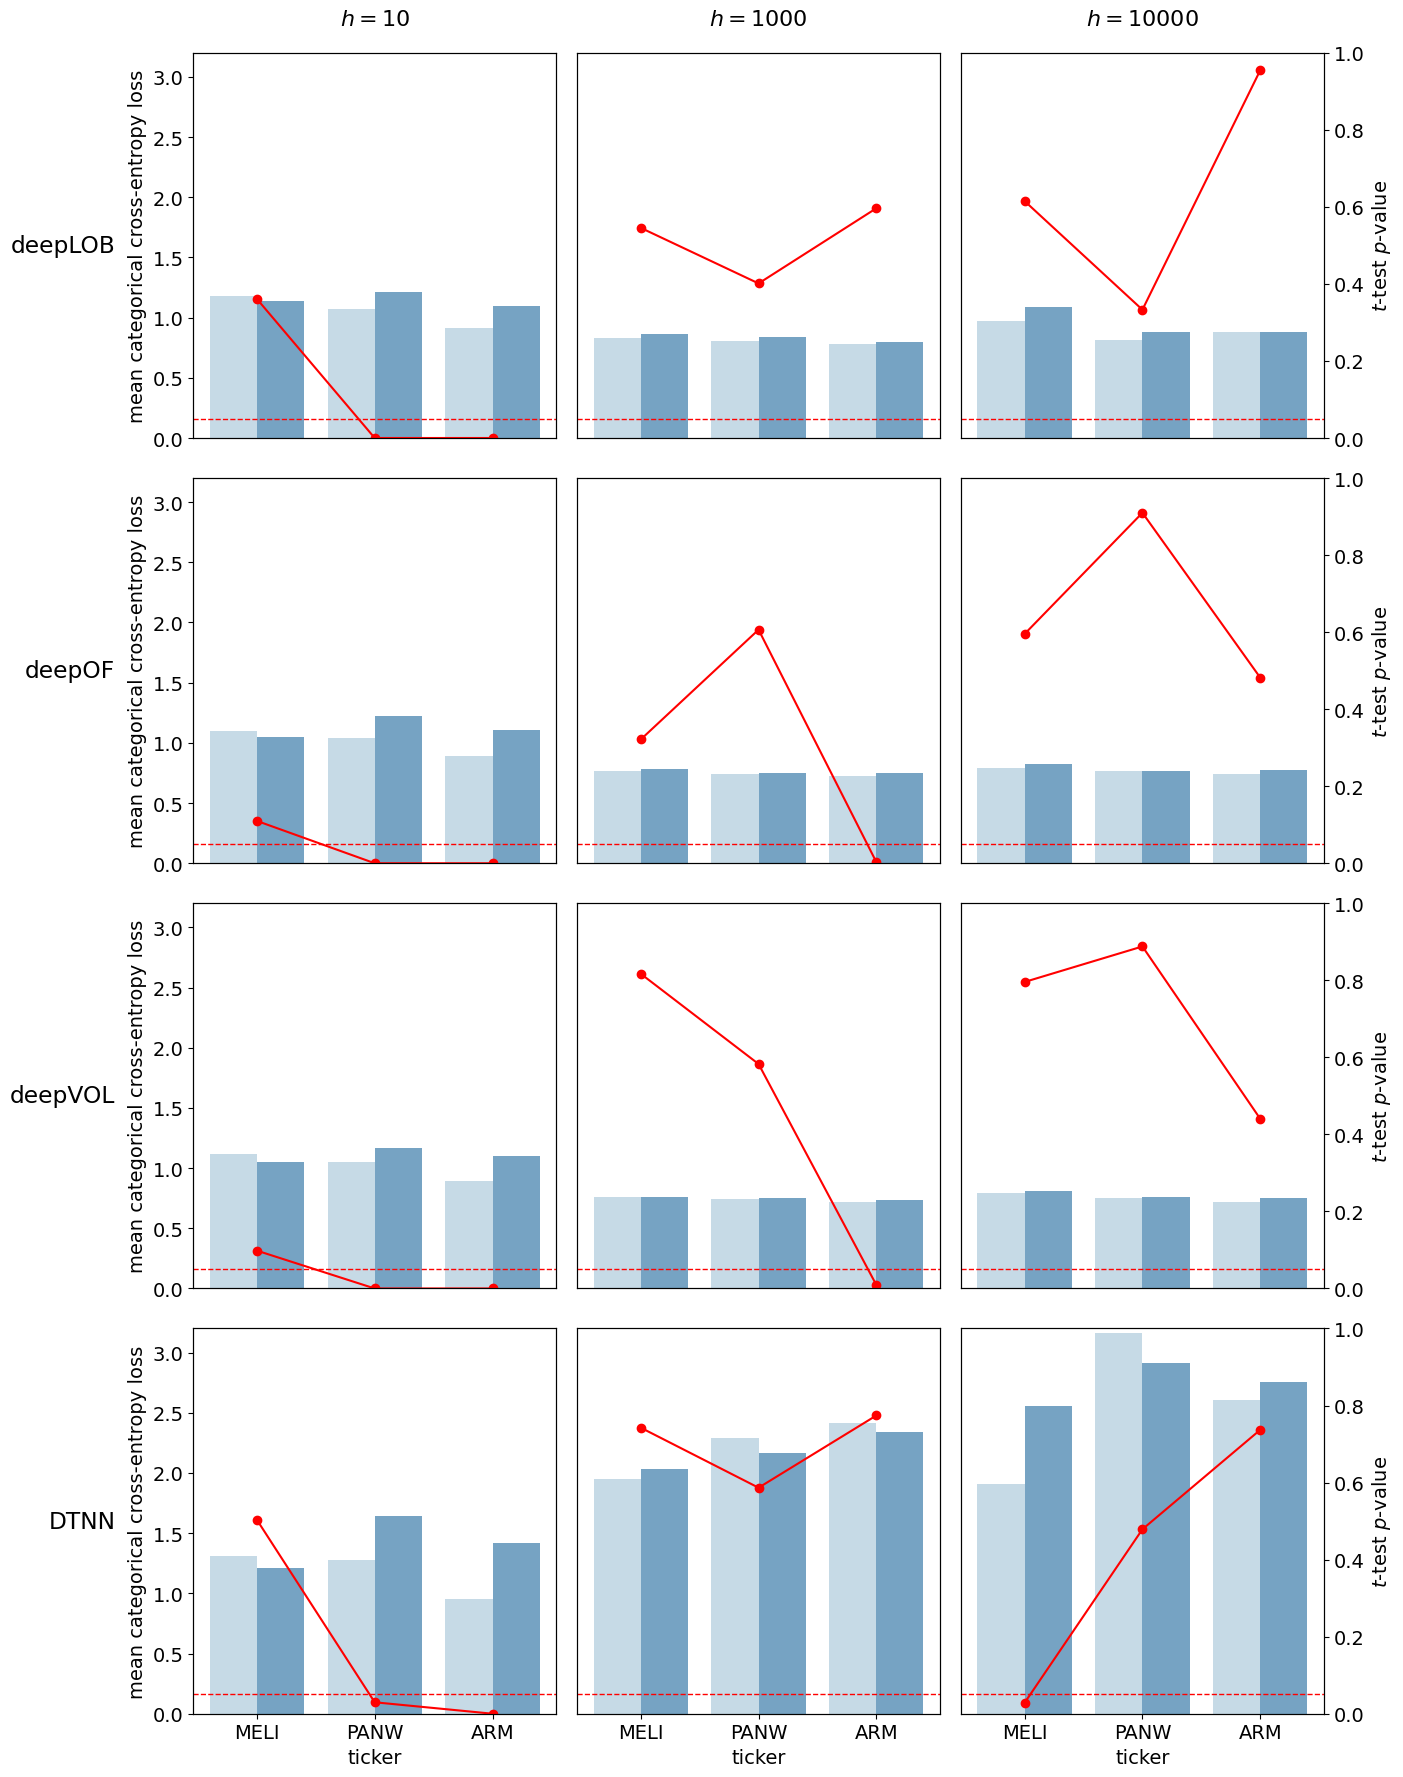

In [462]:
plot_summary(summary_df=impact_pit_mid_summary_df,
             model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
             hs=[10,1000,10000],
             plot_name="impact_pit_mid",
             color_palette="Blues",
             sec_y_axis_max=3.2)

### General trends

1 - For smaller horizons, the concentration of stationary return is higher.

2 - The more liquid the stock is, the concentration in stationary return is lower (even is  smaller horizons);

3 - DTNN tends to have the highest losses, while deepVOL tends to have the lowest. Not the core of the research, but it is an interesting possible research since DTNN is reported to be very good at the benchmark dataset.

### Case specific
1 - The pit-mid returns increases the concentration in stationary return. This is caused because, when there is smoothing, any movement intra-window would cause the return to be considered ascending or descending;

2 - The more statistically significant cases are concentrated in smaller return windows and in higher liquidity. Those are the cases where the shift towards stationary returns is the highest;

3 - In the statistically significant cases, we see the expected trend: the performance of all models get worse.

4 - Also, in general, even when not stat. sig., it seems that the trend is that the performance gets worse. The exception is DTNN, where in some cases it seems the performance gets better. Hypothesis: DTNN is just a bigger model, so the numbers we see are noisier.

In [463]:
# impact - ask bid
impact_ask_bid = summarize_results(eval_type="test",
                  tickers=["MELI","PANW","ARM"],
                  horizons=[0,8,9],
                  # model_types=["DTNN"],
                  model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
                  metrics=["categorical_crossentropy"],
                  train_label_control="uniform_mid_returns",
                  test_label_control="pit_mid_returns",
                  train_label_test="uniform_mid_returns",
                  test_label_test="ask_bid_returns")

impact_ask_bid

,model_type,ticker,orderbook_update,categorical_crossentropy control mean,categorical_crossentropy test mean,categorical_crossentropy p-value,0_control,1_control,2_control,0_test,1_test,2_test
0,deepLOB_L2,MELI,10,1.139054,1.276504,2.582189e-01,0.196562,0.585739,0.217699,0.999474,0.000250,0.000276
0,deepLOB_L2,MELI,1000,0.865355,0.813069,5.575639e-01,0.463252,0.007443,0.529305,0.810149,0.001109,0.188742
0,deepLOB_L2,MELI,10000,1.089268,0.947187,5.127026e-01,0.330122,0.000276,0.669602,0.482321,0.001802,0.515877
0,deepLOB_L2,PANW,10,1.212190,1.001703,4.413057e-04,0.337005,0.341335,0.321660,0.996098,0.002987,0.000915
0,deepLOB_L2,PANW,1000,0.837422,0.929873,1.757968e-01,0.528656,0.007318,0.464026,0.677851,0.008699,0.313451
0,deepLOB_L2,PANW,10000,0.881615,0.926978,6.346129e-01,0.567121,0.001702,0.431176,0.619254,0.003418,0.377328
0,deepLOB_L2,ARM,10,1.095844,0.850718,4.690792e-09,0.410447,0.181664,0.407889,0.989900,0.005987,0.004113
0,deepLOB_L2,ARM,1000,0.797674,0.838509,2.037998e-01,0.506193,0.004932,0.488875,0.624946,0.009138,0.365916
0,deepLOB_L2,ARM,10000,0.883125,0.880354,9.640049e-01,0.537737,0.001518,0.460745,0.577515,0.003008,0.419476
0,deepOF_L2,MELI,10,1.049128,1.314601,7.826522e-04,0.196562,0.585739,0.217699,0.999474,0.000250,0.000276


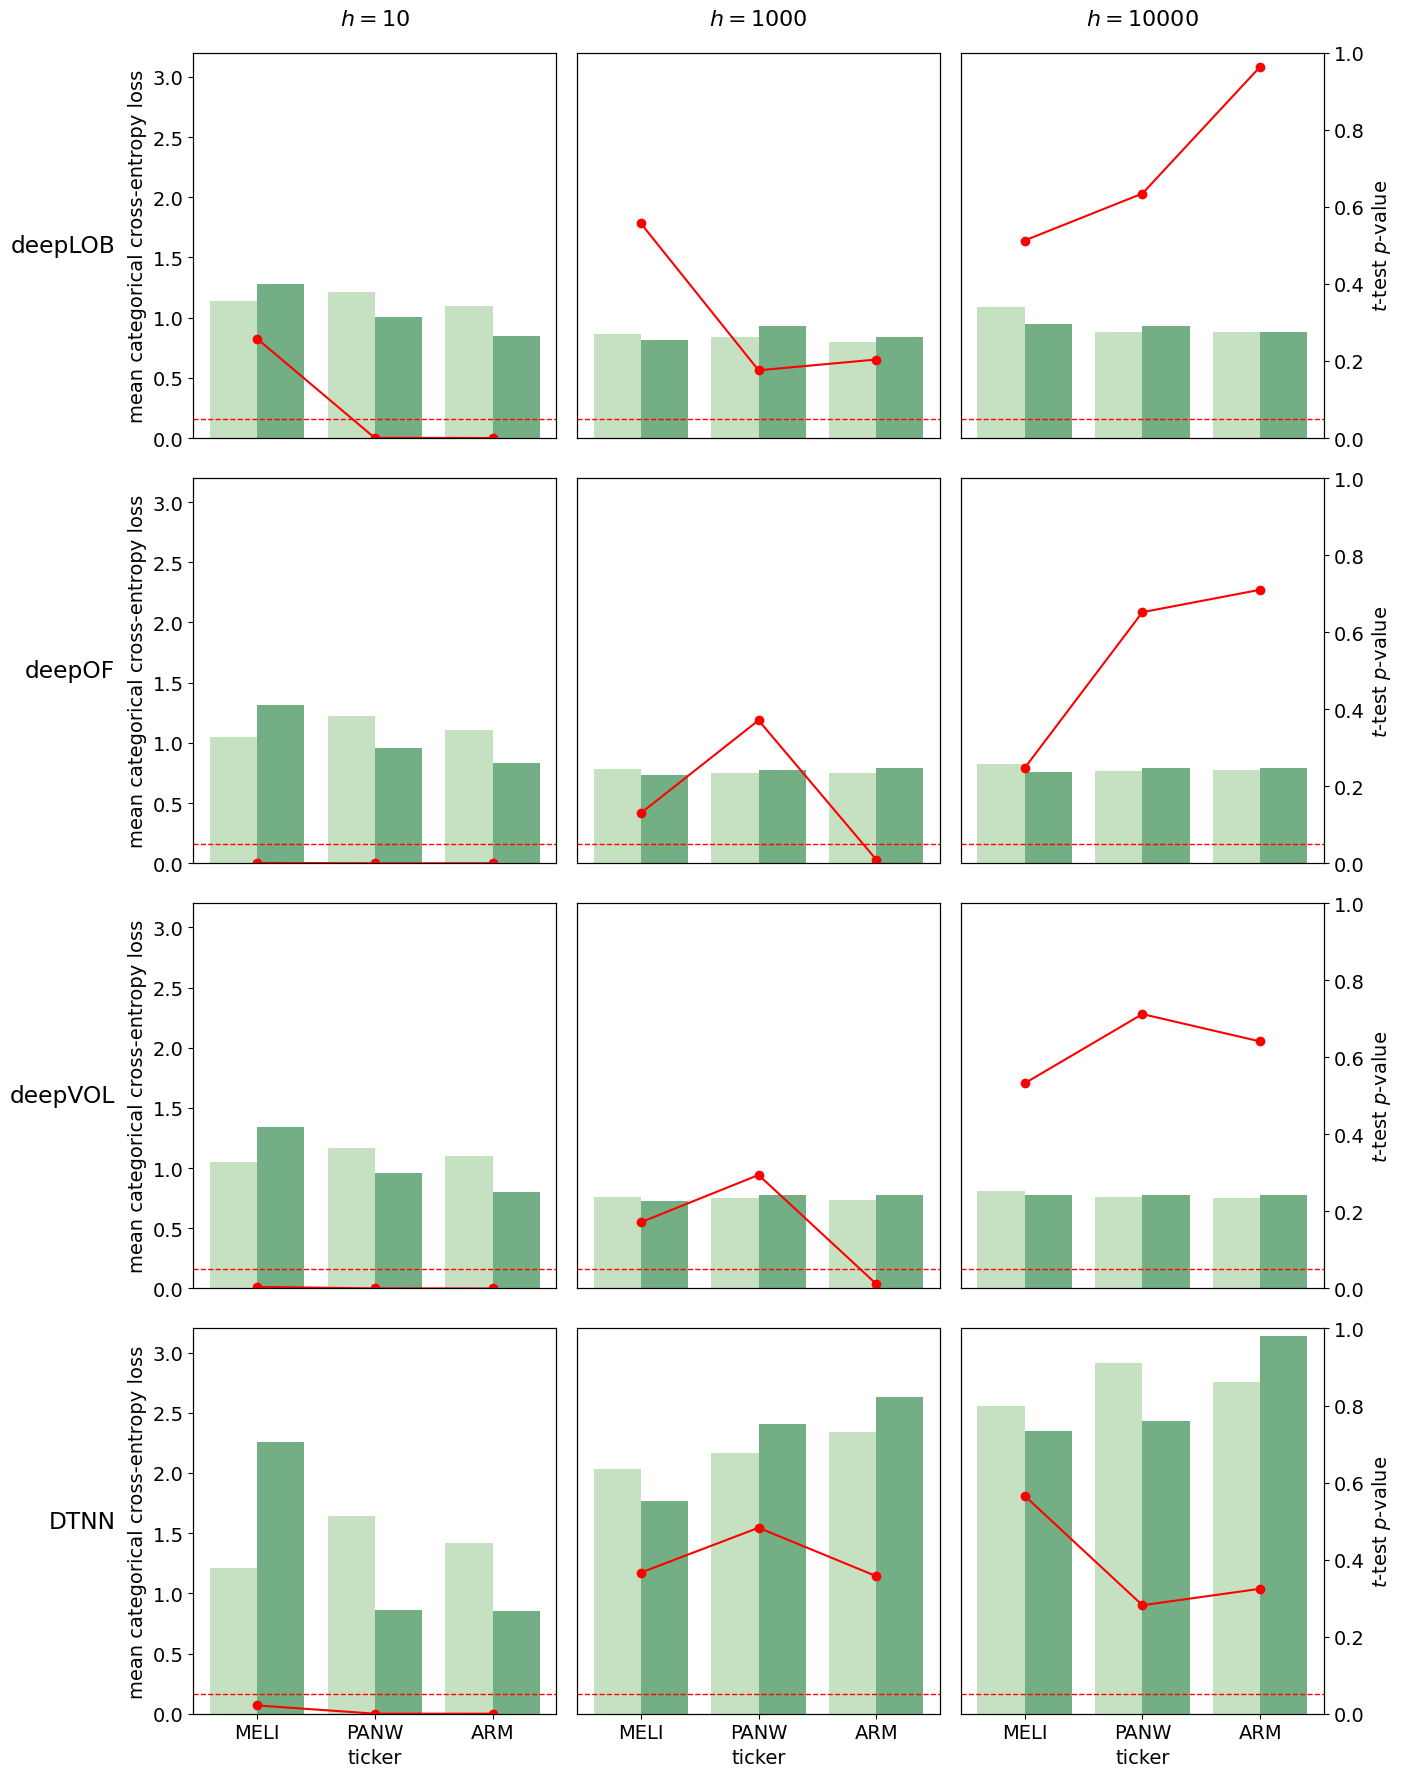

In [464]:
plot_summary(summary_df=impact_ask_bid,
             model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
             hs=[10,1000,10000],
             plot_name="impact_bid_ask",
             color_palette="Greens",
             sec_y_axis_max=3.2)

1 - The returns tend get more concentrated in the down return for smaller windows. Makes sense, since those are the cases where a trading wouldn't "cross the spread". The concentration is higher for less liquid tickers;

2 - Again, most of the statistically significant cases are concentrated in the smaller window (where the shift towards negatives is the highest);

3 - Interestingly, when h=10, only MELI gets worse. The other more liquid stocks get better (PANW and ARM). We believe that is because MELI had a much higher concentration of stationary returns then its counterparts (which had practically none) and it would tend to predict more or less evenly across the 3 labels, while its counterparts would predict mainly across two labels (up or down). When evaluated in uniform-mid returns, all tickers could have 6 error cases (p=0 when t=1; p=0 when t=2; p=1 when t=0; p=1 when t=2; p=2 when t=0; p=2 when t=1). However, when evaluated in ask-bid returns, MELI would have more error cases (p=1 when t=0; p=2 when t=0), then its counterparts (p=2 when t=0). Anyway, this would be a wrong assessment of the performance of the model in the more realistic scenario.

4 - For longer windows, when there is stat. sig., the effect is as expected (the ask-bid preds being worse). This makes sense, because the effect described in 3 has less impact for longer ranges.


In [465]:
# impact - latency 300
impact_latency_300 = summarize_results(eval_type="test",
                  tickers=["MELI","PANW","ARM"],
                  horizons=[0,8,9],
                  # model_types=["DTNN"],
                  model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
                  metrics=["categorical_crossentropy"],
                  train_label_control="uniform_mid_returns",
                  test_label_control="pit_mid_returns",
                  train_label_test="uniform_mid_returns",
                  test_label_test="latency_300_mid_returns")

impact_latency_300

,model_type,ticker,orderbook_update,categorical_crossentropy control mean,categorical_crossentropy test mean,categorical_crossentropy p-value,0_control,1_control,2_control,0_test,1_test,2_test
0,deepLOB_L2,MELI,10,1.139054,1.129439,0.821701,0.196562,0.585739,0.217699,0.191563,0.595034,0.213403
0,deepLOB_L2,MELI,1000,0.865355,0.866817,0.982824,0.463252,0.007443,0.529305,0.463306,0.007490,0.529205
0,deepLOB_L2,MELI,10000,1.089268,1.106891,0.947089,0.330122,0.000276,0.669602,0.330062,0.000283,0.669655
0,deepLOB_L2,PANW,10,1.212190,1.232917,0.459570,0.337005,0.341335,0.321660,0.318102,0.379213,0.302685
0,deepLOB_L2,PANW,1000,0.837422,0.822881,0.697527,0.528656,0.007318,0.464026,0.528849,0.007182,0.463969
0,deepLOB_L2,PANW,10000,0.881615,0.887765,0.942178,0.567121,0.001702,0.431176,0.567250,0.001745,0.431004
0,deepLOB_L2,ARM,10,1.095844,1.143811,0.003780,0.410447,0.181664,0.407889,0.394261,0.213627,0.392112
0,deepLOB_L2,ARM,1000,0.797674,0.803251,0.768084,0.506193,0.004932,0.488875,0.506040,0.004975,0.488985
0,deepLOB_L2,ARM,10000,0.883125,0.841984,0.449084,0.537737,0.001518,0.460745,0.537787,0.001527,0.460685
0,deepOF_L2,MELI,10,1.049128,1.048061,0.974434,0.196562,0.585739,0.217699,0.191563,0.595034,0.213403


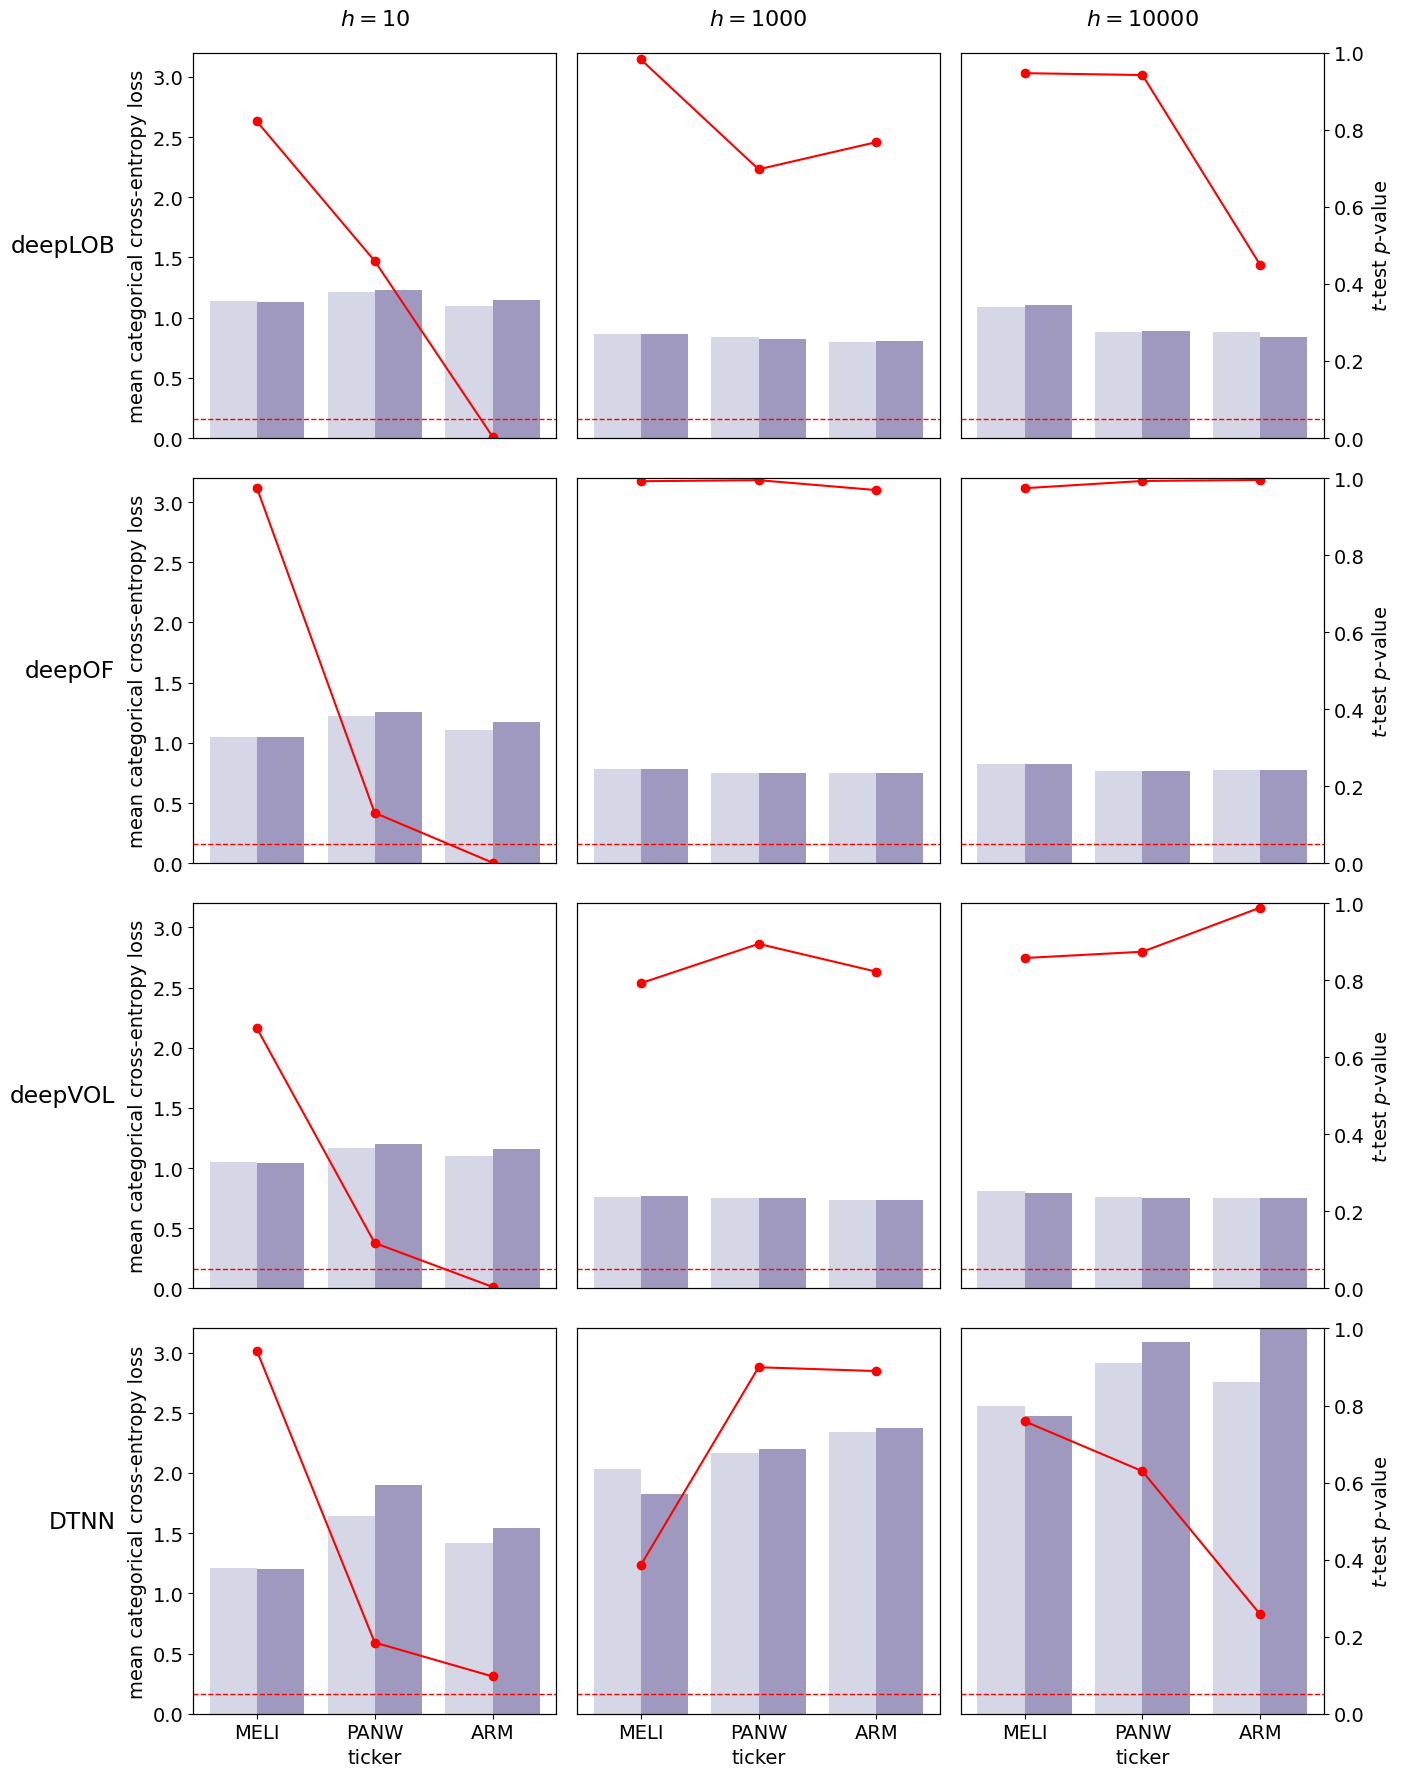

In [466]:
plot_summary(summary_df=impact_latency_300,
             model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
             hs=[10,1000,10000],
             plot_name="impact_latency_300",
             color_palette="Purples",
             sec_y_axis_max=3.2)

1 - As expected, there is no big shift in the returns distribution;

2 - Again, the stat. sig. results are mainly concentrated in the cases where the horizon is short and the liquidity of the stocks is higher.

3 - However, they only really happen for more liquid tickers (i.e. ARM);

4 - As expected, it makes predictions worse. However, the numbers do not seem as worse as we would expect when considering that 30% to 40% of the price changes are impact. Hypothesis: there is change in price, but not necessarily change in direction.

In [469]:
# Model assump - pit mid
model_assump_pit_mid = summarize_results(eval_type="test",
                  tickers=["MELI","PANW","ARM"],
                  horizons=[0,8,9],
                  # model_types=["DTNN"],
                  model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
                  metrics=["categorical_crossentropy"],
                  train_label_control="uniform_mid_returns",
                  test_label_control="pit_mid_returns",
                  train_label_test="pit_mid_returns",
                  test_label_test="pit_mid_returns")

model_assump_pit_mid

,model_type,ticker,orderbook_update,categorical_crossentropy control mean,categorical_crossentropy test mean,categorical_crossentropy p-value,0_control,1_control,2_control,0_test,1_test,2_test
0,deepLOB_L2,MELI,10,1.139054,1.098442,4.213501e-01,0.196562,0.585739,0.217699,0.196562,0.585739,0.217699
0,deepLOB_L2,MELI,1000,0.865355,0.856906,8.985008e-01,0.463252,0.007443,0.529305,0.463252,0.007443,0.529305
0,deepLOB_L2,MELI,10000,1.089268,0.710902,7.649171e-02,0.330122,0.000276,0.669602,0.330122,0.000276,0.669602
0,deepLOB_L2,PANW,10,1.212190,1.065130,1.701130e-04,0.337005,0.341335,0.321660,0.337005,0.341335,0.321660
0,deepLOB_L2,PANW,1000,0.837422,0.785792,1.823752e-01,0.528656,0.007318,0.464026,0.528656,0.007318,0.464026
0,deepLOB_L2,PANW,10000,0.881615,0.783571,2.117955e-01,0.567121,0.001702,0.431176,0.567121,0.001702,0.431176
0,deepLOB_L2,ARM,10,1.095844,1.032218,3.923710e-03,0.410447,0.181664,0.407889,0.410447,0.181664,0.407889
0,deepLOB_L2,ARM,1000,0.797674,0.792850,8.403613e-01,0.506193,0.004932,0.488875,0.506193,0.004932,0.488875
0,deepLOB_L2,ARM,10000,0.883125,0.835415,5.397985e-01,0.537737,0.001518,0.460745,0.537737,0.001518,0.460745
0,deepOF_L2,MELI,10,1.049128,0.728201,3.495431e-06,0.196562,0.585739,0.217699,0.196562,0.585739,0.217699


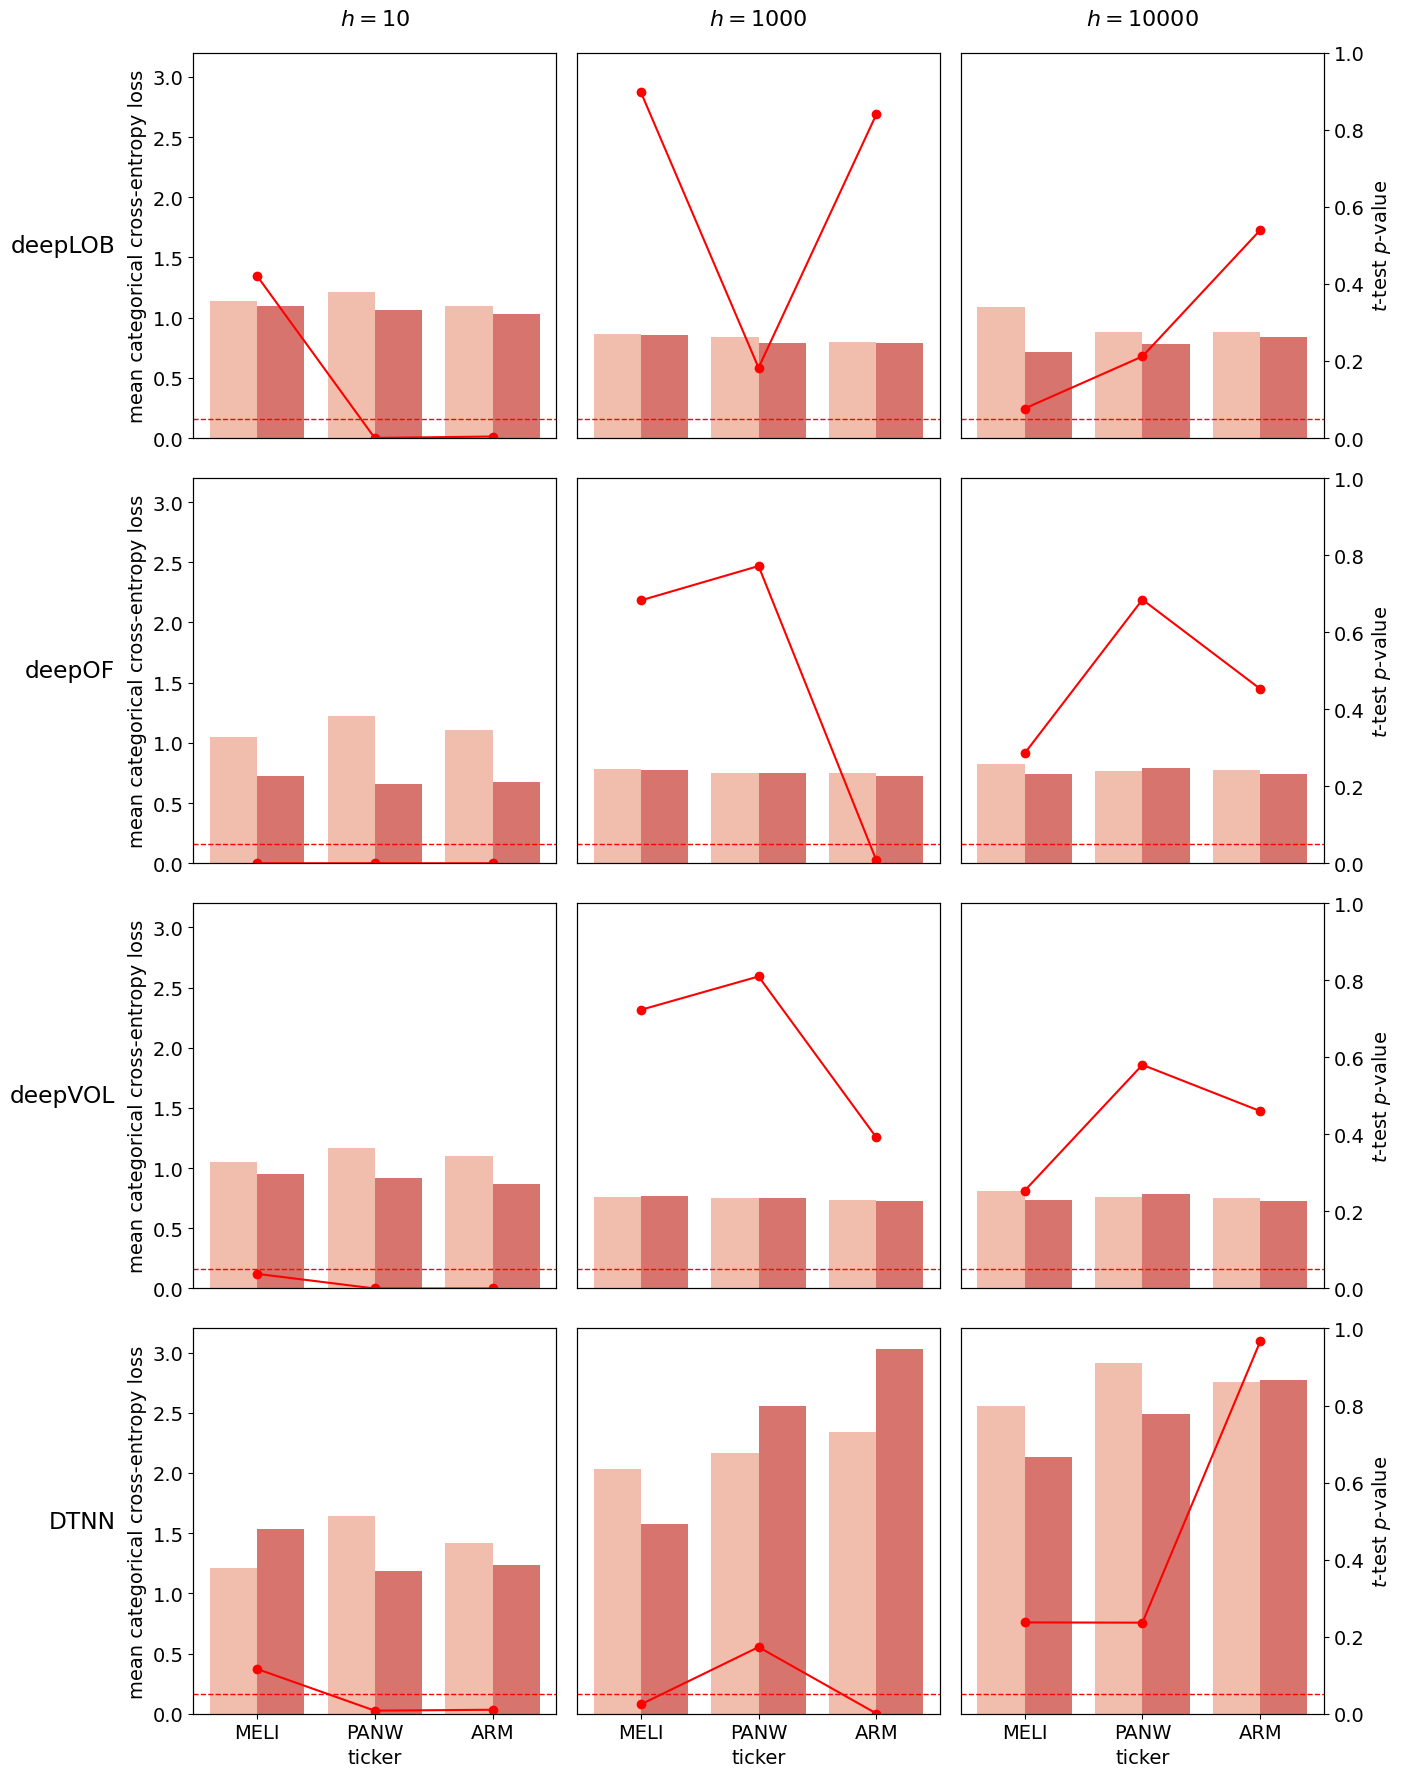

In [470]:
plot_summary(summary_df=model_assump_pit_mid,
             model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
             hs=[10,1000,10000],
             plot_name="model_assump_pit_mid",
             color_palette="Reds",
             sec_y_axis_max=3.2)

1 - Training the model in pit-mid returns seem to improve its performance, specially in the short range. Again, this is most likely driven by the closer distribution to the test data;

2 - The impact in the deepOF and deepVOL is the greatest. Hypothesis: since those architectures use a more robust representation of the orderbook, they suffer less from the added noise of unif. pit mid returns;

3 - For longer horizons, there seems to be little impact of training the models using pit-mid, most likely because the change in distribution is not so big. Except for DTNN, where the pattern is unclear. Most likely because the model is big and there is little data to train on it.

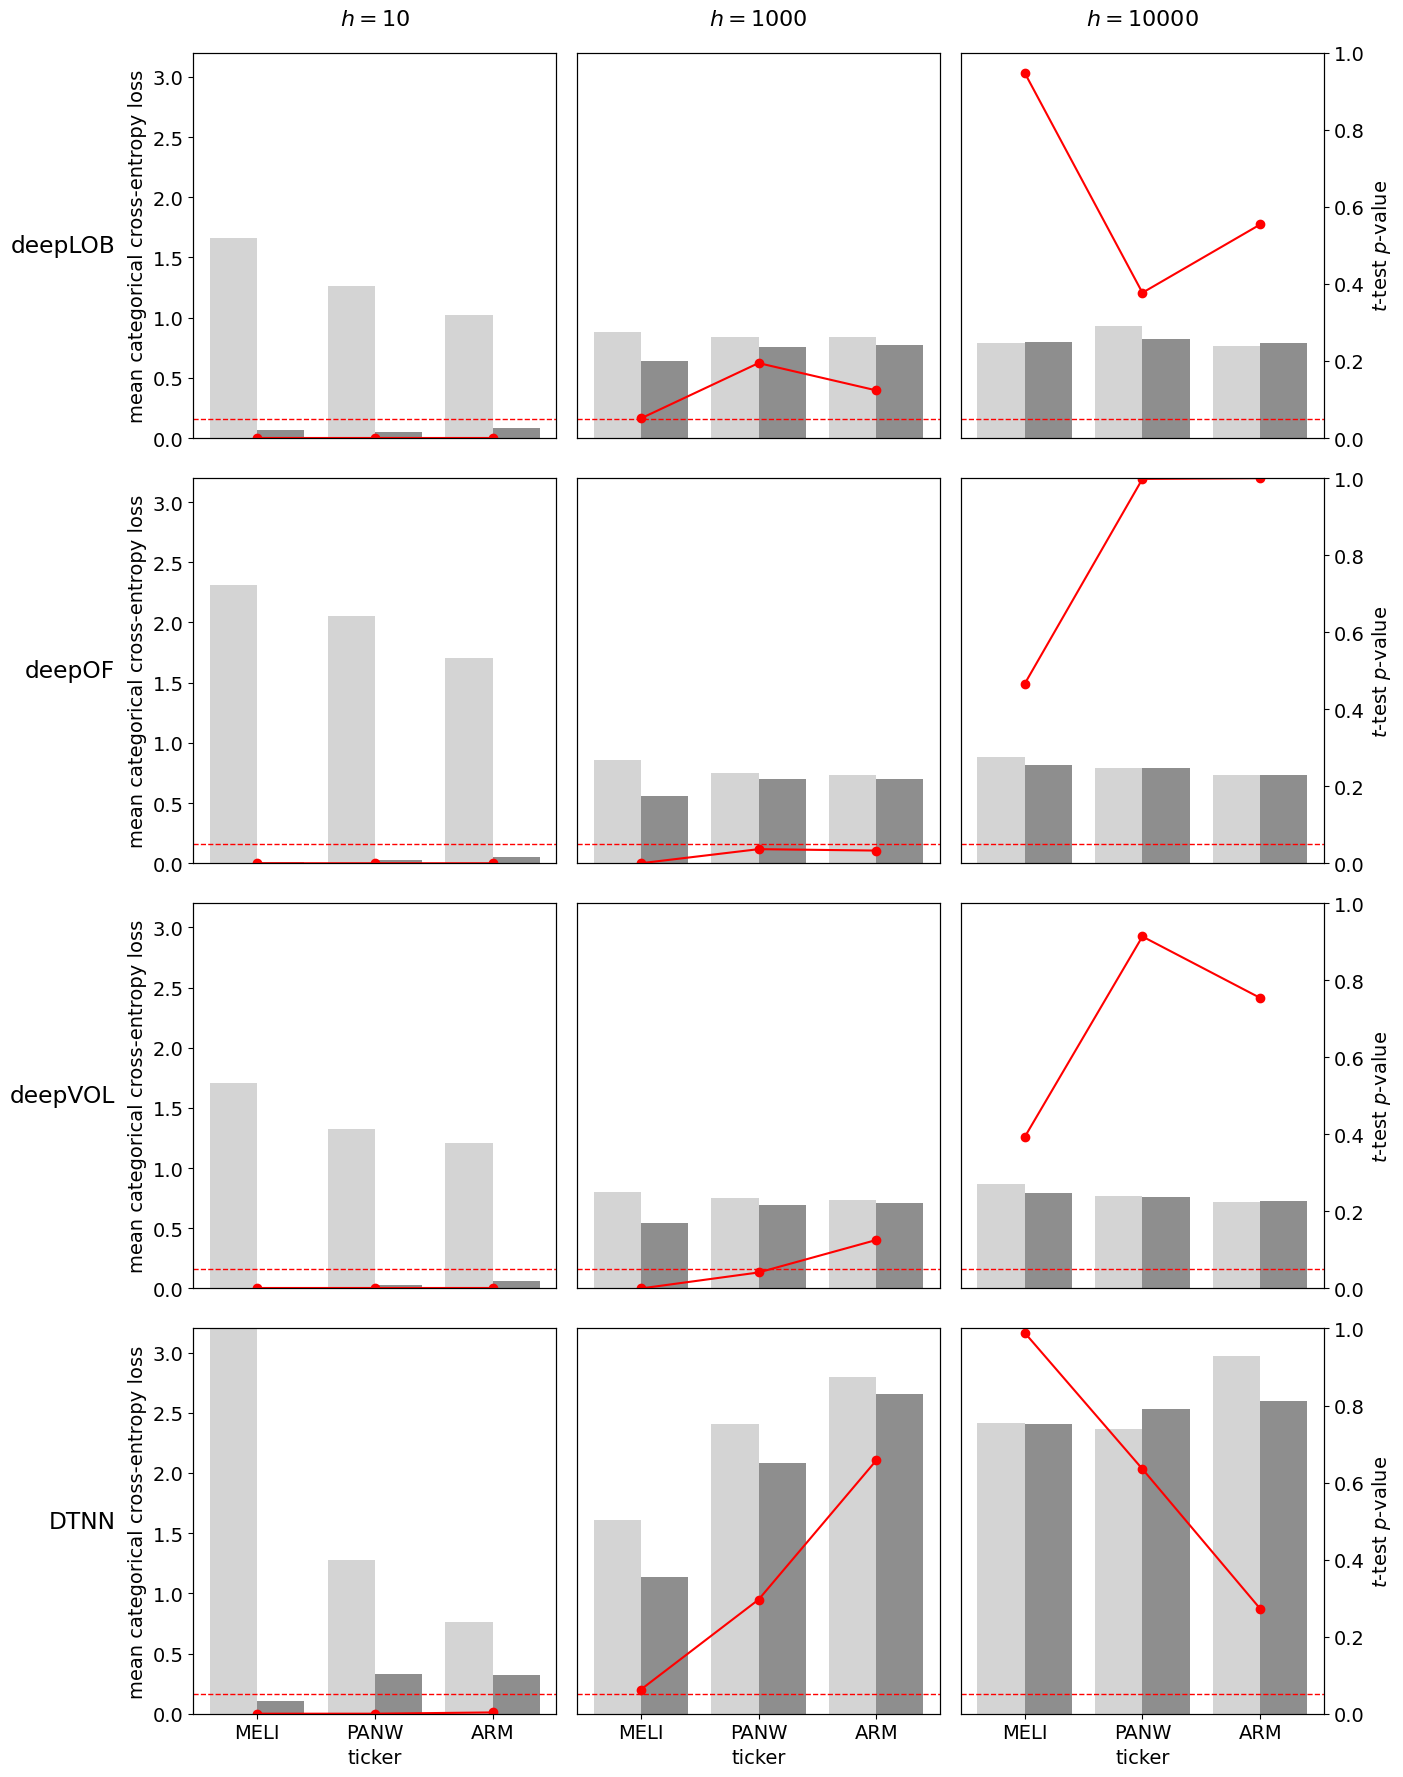

In [471]:
# Model assump - ask bid
model_assump_bid_ask = summarize_results(eval_type="test",
                  tickers=["MELI","PANW","ARM"],
                  horizons=[0,8,9],
                  # model_types=["DTNN"],
                  model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
                  metrics=["categorical_crossentropy"],
                  train_label_control="pit_mid_returns",
                  test_label_control="ask_bid_returns",
                  train_label_test="ask_bid_returns",
                  test_label_test="ask_bid_returns")

plot_summary(summary_df=model_assump_bid_ask,
             model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
             hs=[10,1000,10000],
             plot_name="model_assump_bid_ask",
             color_palette="Greys",
             sec_y_axis_max=3.2)

1 - There is massive performance improvement when training the model using ask-to-bid returns, specially in the short prediction horizon of h=10. This makes sense because, when h=10, the problem basically turns into a single class model, when all returns are downwards. In practical applications, this wouldn't be able to bring profitable opportunities, however, at least, we would avoid entering loosing positions; 

2 - Interestingly there is even some interesting improvement when h=1000, meaning that, when there are profitable opportunities, modelling the ask-to-bid returns could still be useful;

3 - The impact vanishes at h=10000;

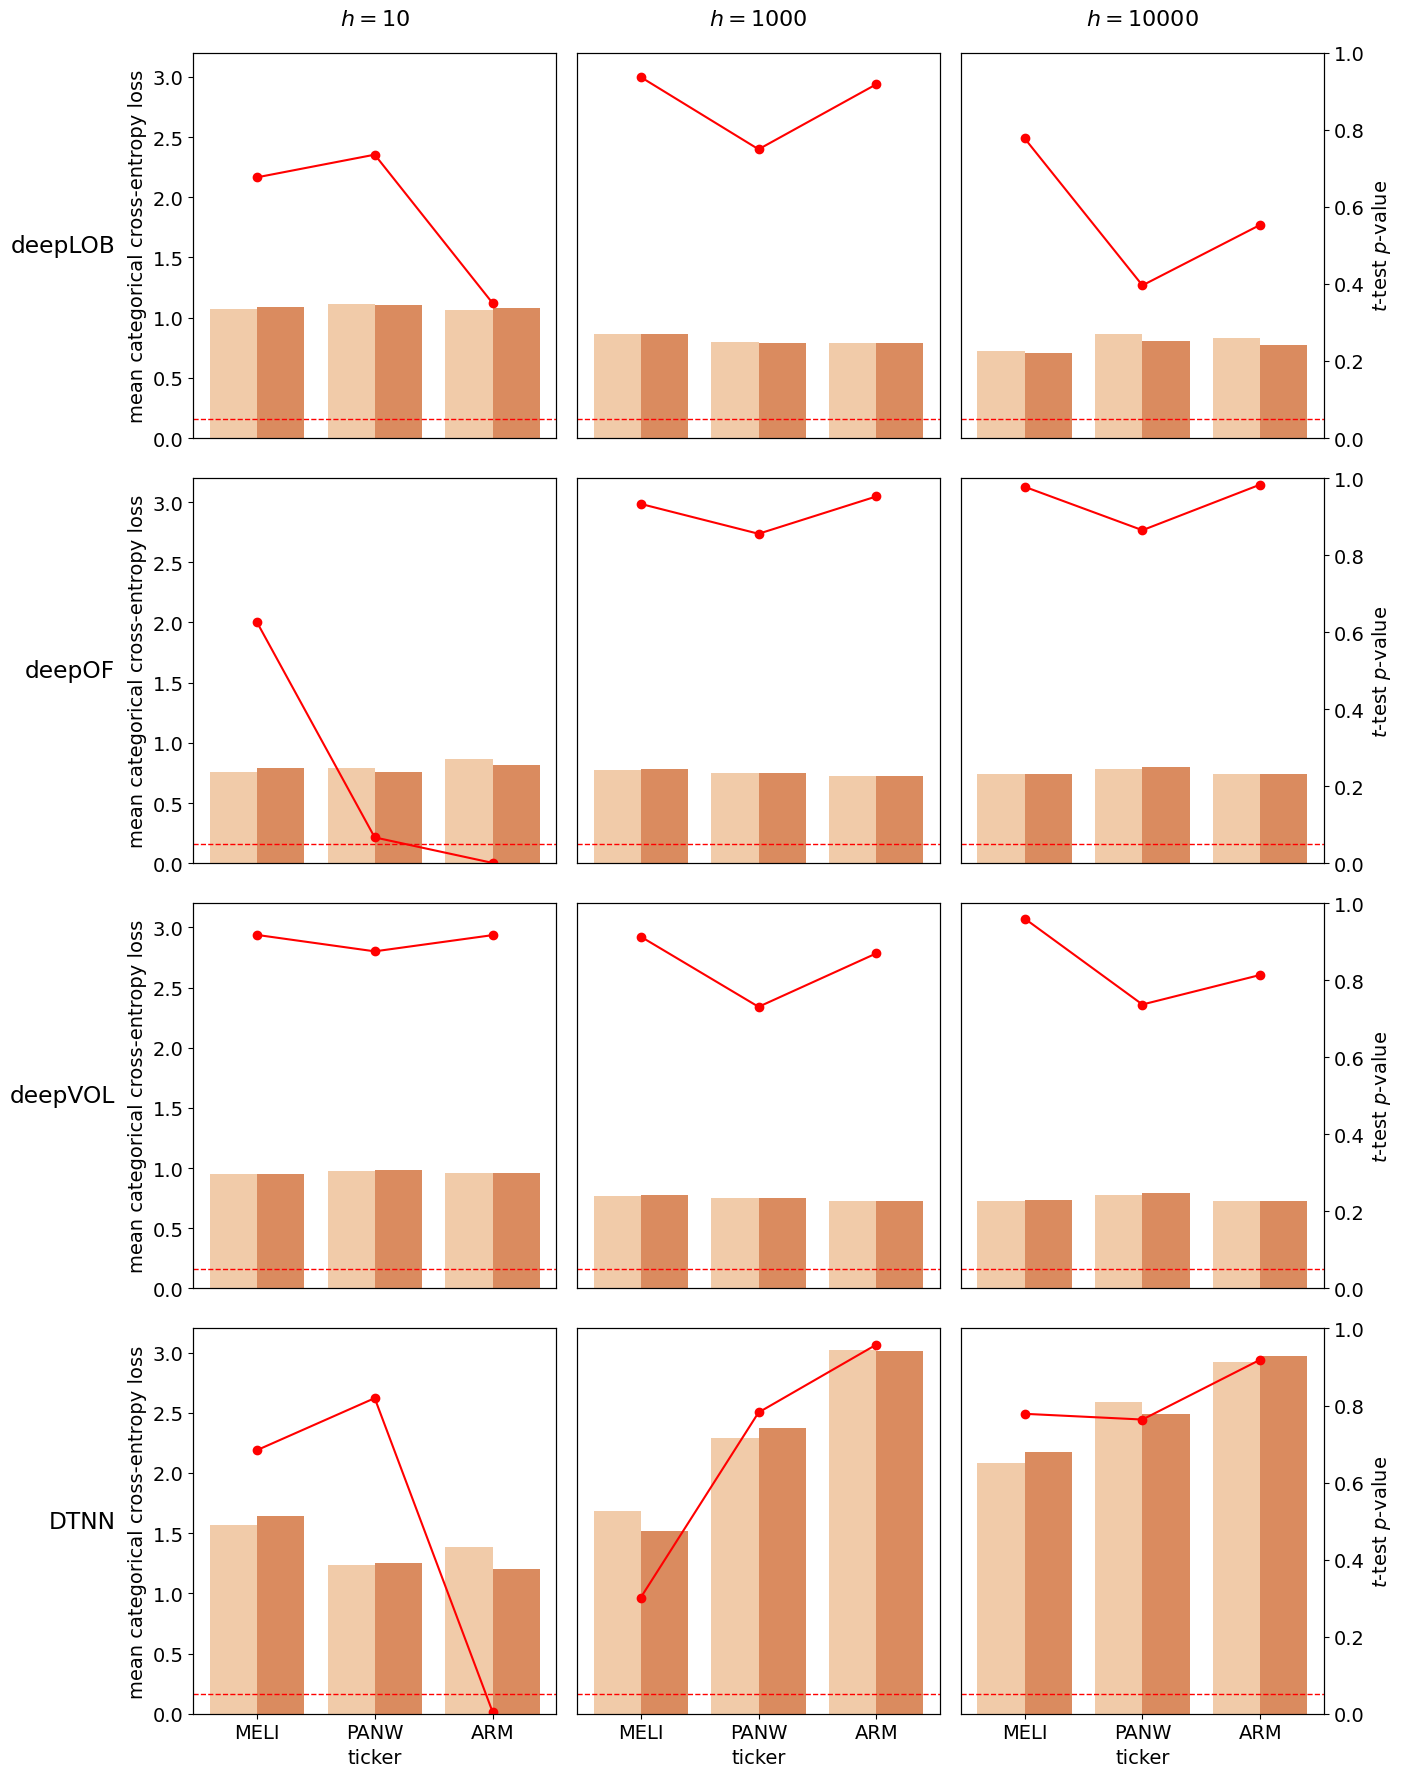

In [476]:
# model assump - latency 300
model_assump_latency_300 = summarize_results(eval_type="test",
                  tickers=["MELI","PANW","ARM"],
                  horizons=[0,8,9],
                  # model_types=["DTNN"],
                  model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
                  metrics=["categorical_crossentropy"],
                  train_label_control="pit_mid_returns",
                  test_label_control="latency_300_mid_returns",
                  train_label_test="latency_300_mid_returns",
                  test_label_test="latency_300_mid_returns")

plot_summary(summary_df=model_assump_latency_300,
             model_types=["deepLOB_L2","deepOF_L2","deepVOL_L2","DTNN"],
             hs=[10,1000,10000],
             plot_name="model_assump_latency_300",
             color_palette="Oranges",
             sec_y_axis_max=3.2)

1 - Although a few show performance improvement, the impact of including the latency as part of the modelling is minimal. This makes sense considering that the we saw that the latency does not change the label distributions very drastically and, when it does, it is most likely in a random pattern that the model has difficulty learning.